In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vtk_rw import read_vtk
import lmfit
import pandas as pd

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
colors = sns.color_palette('cubehelix', 10)

### Load data

In [4]:
hemi='rh'

mesh_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_%s_d.vtk'%hemi
sulc_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_%s_d_sulc.npy'%hemi
mask_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/masks/%s_fullmask.npy'%hemi
embed_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/embed/connectivity/%s_smooth_3_embed_10.npy'%hemi
t1_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/smooth_3/avg_%s_profiles_smooth_3.npy'%hemi
r1_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/smooth_3/avg_%s_r1_smooth_3.npy'%hemi

In [5]:
v,f,d = read_vtk(mesh_file)
mask = np.load(mask_file)
embedding = np.load(embed_file)
t1_profiles = np.load(t1_file)
r1_profiles = np.load(r1_file)
sulc = np.load(sulc_file)

### Mask and average

In [6]:
t1_profiles[mask]=0
r1_profiles[mask]=0

In [7]:
t1_avg = np.mean(t1_profiles[:,3:8], axis=1)
r1_avg = np.mean(r1_profiles[:,3:8], axis=1)

In [8]:
scatter_t1avg = np.delete(t1_avg, mask)
scatter_r1avg = np.delete(r1_avg, mask)

scatter_embed_t1 = np.delete(embedding, mask, axis=0)
scatter_embed_r1 = np.delete(embedding, mask, axis=0)

t1_idx=np.where(scatter_t1avg<=1500)
scatter_t1avg = np.delete(scatter_t1avg, t1_idx)
scatter_embed_t1 = np.delete(scatter_embed_t1, t1_idx, axis=0)

r1_idx=np.where(scatter_r1avg>(1./1500))
scatter_r1avg = np.delete(scatter_r1avg, r1_idx)
scatter_embed_r1 = np.delete(scatter_embed_r1, r1_idx, axis=0)

### Plot 2D histogramms

In [9]:
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.3)

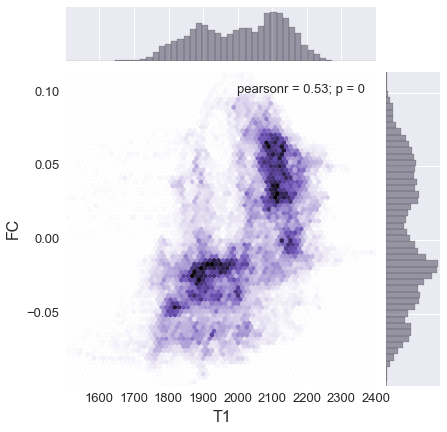

In [10]:
g = sns.jointplot(scatter_t1avg, scatter_embed_t1[:,0] , kind="hex", size=6, color=colors[0])
g.set_axis_labels('T1', 'FC', fontsize=16)

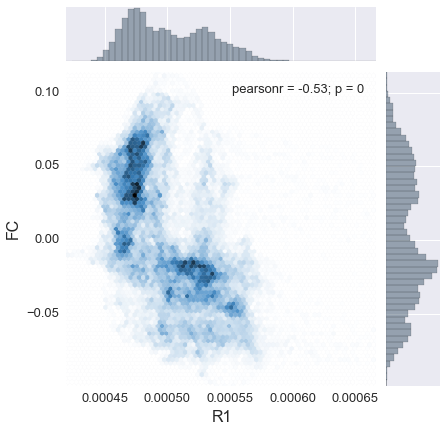

In [11]:
g = sns.jointplot(scatter_r1avg, scatter_embed_r1[:,0],  kind="hex", size=6, color=colors[1])
g.set_axis_labels('R1', 'FC', fontsize=16)

### Normalize data to get sensible model comparison

"Note that the calculation of chi-square and reduced chi-square assume that the returned residual function is scaled properly to the uncertainties in the data. For these statistics to be meaningful, the person writing the function to be minimized must scale them properly."

Is this valid, given the data are not normally distributed? 

In [12]:
t1_norm = (scatter_t1avg - np.mean(scatter_t1avg)) / (np.std(scatter_t1avg))
r1_norm = (scatter_r1avg - np.mean(scatter_r1avg)) / (np.std(scatter_r1avg))
embed1_t1_norm = (scatter_embed_t1[:,0] - np.mean(scatter_embed_t1[:,0])) / (np.std(scatter_embed_t1[:,0]))
embed1_r1_norm = (scatter_embed_r1[:,0] - np.mean(scatter_embed_r1[:,0])) / (np.std(scatter_embed_r1[:,0]))

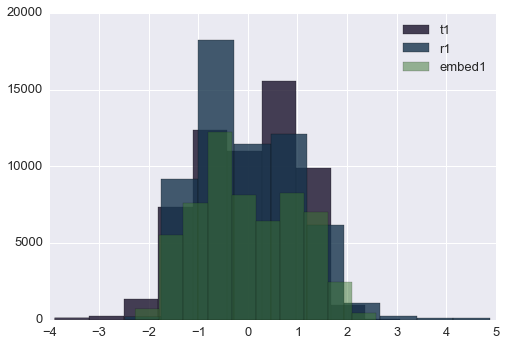

In [13]:
plt.hist(t1_norm, alpha=0.8, color=colors[0], label='t1');
plt.hist(r1_norm, alpha=0.8, color=colors[1], label='r1');
#plt.hist(embed1_t1_norm, alpha=0.7, color=colors[2], label='embed1_t1');
plt.hist(embed1_r1_norm, alpha=0.5, color=colors[3], label='embed1');
plt.legend()

### Model

In [14]:
def custom_plot(x, y, res, xlabel=None, ylabel=None, data_color=colors[1]):
    fig=plt.figure(figsize=(12,5))
    fig.add_subplot(121)
    plt.plot(x, y, alpha=0.1, marker='.', linestyle='None', color=data_color)
    plt.plot(x, res.best_fit, color='black', linestyle='None', marker='.', markersize=.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    fig.add_subplot(122)
    res.plot_residuals(data_kws={'alpha':0.1, 'color':'grey', 'marker':'.'}, fit_kws={'color':'k', 'linewidth':2})
    
def custom_report(res, label):
    print '##### %s #####'%label
    print res.fit_report()
    print 'BIC', res.bic
    print 'AIC', res.aic
    print ''

In [15]:
def fit_simple(model, x, y, t1type, xlabel, ylabel, color):
    
    pars = model.guess(y, x=x)
    out = model.fit(y, pars, x=x)
    
    custom_report(out, t1type)
    custom_plot(x,y, out, xlabel=xlabel, ylabel=ylabel, data_color=color)
    
    return out

In [16]:
def fit_composite_const(model, x, y, t1type, xlabel, ylabel, color):
    
    const_model = lmfit.models.LinearModel(prefix='const_')
    const_model.set_param_hint(name='slope', value=0, vary=False)
    comp_model = model + const_model
    
    pars = const_model.make_params(intercept=y.min())
    pars += model.guess(y, x=x)
    out = comp_model.fit(y, pars, x=x)
    
    custom_report(out, t1type)
    custom_plot(x,y, out, xlabel=xlabel, ylabel=ylabel, data_color=color)
    
    return out

### Linear fit

##### T1avg #####
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # function evals   = 5
    # data points      = 58921
    # variables        = 2
    chi-square         = 42125.002
    reduced chi-square = 0.715
[[Variables]]
    slope:       0.53390974 +/- 0        (0.00%) (init= 0.5339097)
    intercept:  -3.5310e-16 +/- 0        (0.00%) (init=-3.530957e-16)
[[Correlations]] (unreported correlations are <  0.100)

BIC -19747.334311
AIC -19765.3022166

##### R1avg #####
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # function evals   = 5
    # data points      = 58818
    # variables        = 2
    chi-square         = 42332.394
    reduced chi-square = 0.720
[[Variables]]
    slope:      -0.52941633 +/- 0        (0.00%) (init=-0.5294163)
    intercept:  -1.6068e-15 +/- 0        (0.00%) (init=-1.606801e-15)
[[Correlations]] (unreported correlations are <  0.100)

BIC -19321.0011153
AIC -19338.9655217



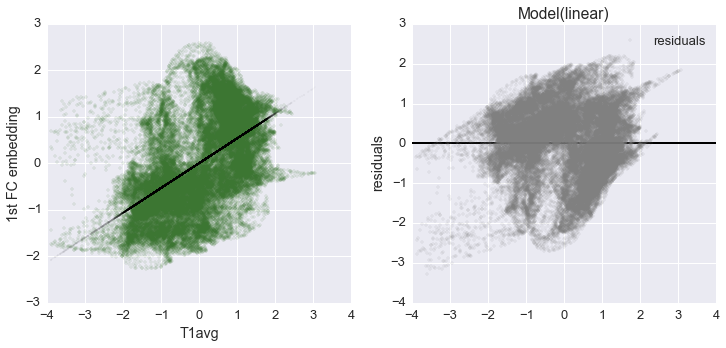

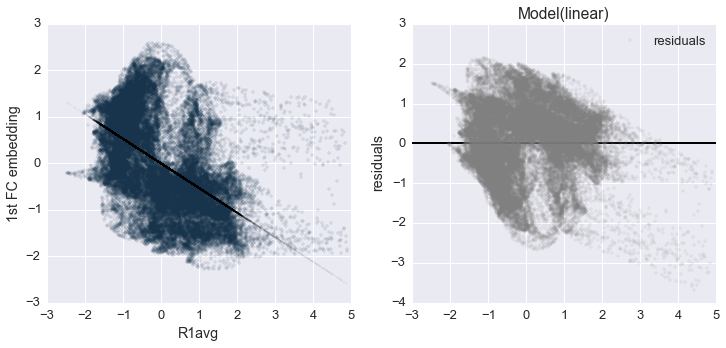

In [17]:
lin_mod = lmfit.models.LinearModel()

lin_t1 = fit_simple(lin_mod, 
                        x=t1_norm, y=embed1_t1_norm,
                        t1type='T1avg',
                        xlabel='T1avg',
                        ylabel='1st FC embedding', 
                        color=colors[3])


lin_r1 = fit_simple(lin_mod,
                        x=r1_norm, y=embed1_r1_norm, 
                        t1type='R1avg',
                        xlabel='R1avg',
                        ylabel='1st FC embedding', 
                        color=colors[1])

### Quadratic fit

##### T1avg #####
[[Model]]
    Model(parabolic)
[[Fit Statistics]]
    # function evals   = 6
    # data points      = 58921
    # variables        = 3
    chi-square         = 42111.000
    reduced chi-square = 0.715
[[Variables]]
    a:   0.01350004 +/- 0.003050 (22.59%) (init= 0.01350004)
    b:   0.53836538 +/- 0.003625 (0.67%) (init= 0.5383654)
    c:  -0.01350004 +/- 0.004629 (34.29%) (init=-0.01350004)
[[Correlations]] (unreported correlations are <  0.100)
    C(a, c)                      = -0.659 
    C(a, b)                      =  0.278 
    C(b, c)                      = -0.183 

BIC -19754.9384409
AIC -19781.8902994

##### R1avg #####
[[Model]]
    Model(parabolic)
[[Fit Statistics]]
    # function evals   = 6
    # data points      = 58818
    # variables        = 3
    chi-square         = 41765.287
    reduced chi-square = 0.710
[[Variables]]
    a:   0.07446149 +/- 0.002634 (3.54%) (init= 0.0744615)
    b:  -0.57589088 +/- 0.003844 (0.67%) (init=-0.5758909)
    c:  -0

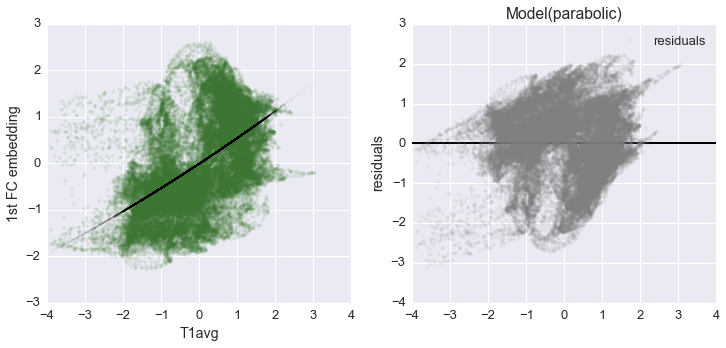

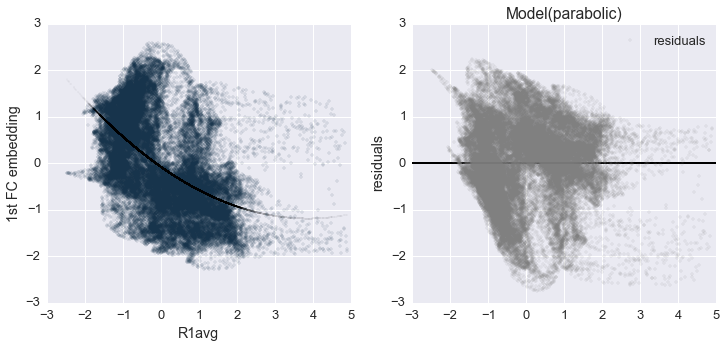

In [18]:
quad_mod = lmfit.models.QuadraticModel()

quad_t1 = fit_simple(quad_mod, 
                        x=t1_norm, y=embed1_t1_norm,
                        t1type='T1avg',
                        xlabel='T1avg',
                        ylabel='1st FC embedding', 
                        color=colors[3])


quad_r1 = fit_simple(quad_mod, 
                        x=r1_norm, y=embed1_r1_norm, 
                        t1type='R1avg',
                        xlabel='R1avg',
                        ylabel='1st FC embedding', 
                        color=colors[1])

### Polynomial model degree=3

##### T1avg #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 7
    # data points      = 58921
    # variables        = 4
    chi-square         = 40418.213
    reduced chi-square = 0.686
[[Variables]]
    c0:   0.05811932 +/- 0.004759 (8.19%) (init= 0.05811933)
    c1:   0.71972837 +/- 0.005093 (0.71%) (init= 0.7197284)
    c2:  -0.08748654 +/- 0.003614 (4.13%) (init=-0.08748655)
    c3:  -0.08897915 +/- 0.001791 (2.01%) (init=-0.08897916)
[[Correlations]] (unreported correlations are <  0.100)
    C(c1, c3)                    = -0.717 
    C(c0, c2)                    = -0.690 
    C(c2, c3)                    =  0.562 
    C(c0, c3)                    = -0.303 
    C(c1, c2)                    = -0.243 

BIC -22160.3940395
AIC -22196.3298508

##### R1avg #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 7
    # data points      = 58818
    # variables        = 4
    chi-square         = 40922.413
    reduced chi-square 

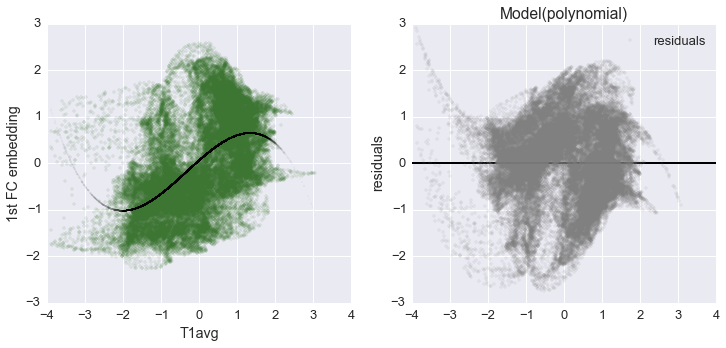

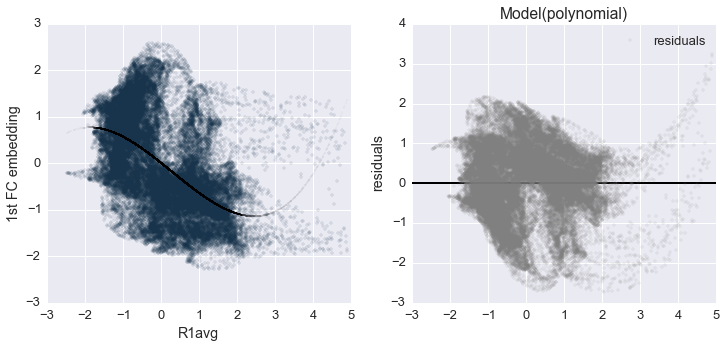

In [19]:
poly3_mod = lmfit.models.PolynomialModel(degree=3)

poly3_t1 = fit_simple(poly3_mod, 
                        x=t1_norm, y=embed1_t1_norm,
                        t1type='T1avg',
                        xlabel='T1avg',
                        ylabel='1st FC embedding', 
                        color=colors[3])


poly3_r1 = fit_simple(poly3_mod, 
                        x=r1_norm, y=embed1_r1_norm, 
                        t1type='R1avg',
                        xlabel='R1avg',
                        ylabel='1st FC embedding', 
                        color=colors[1])

### Polynomial fit degree=4

##### T1avg #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 8
    # data points      = 58921
    # variables        = 5
    chi-square         = 40099.981
    reduced chi-square = 0.681
[[Variables]]
    c0:   0.01134291 +/- 0.005210 (45.94%) (init= 0.01134292)
    c1:   0.79894902 +/- 0.006258 (0.78%) (init= 0.798949)
    c2:  -0.00131032 +/- 0.005370 (409.86%) (init=-0.001310326)
    c3:  -0.13436885 +/- 0.002754 (2.05%) (init=-0.1343689)
    c4:  -0.02253788 +/- 0.001042 (4.62%) (init=-0.02253789)
[[Correlations]] (unreported correlations are <  0.100)
    C(c1, c3)                    = -0.822 
    C(c3, c4)                    =  0.762 
    C(c2, c4)                    = -0.742 
    C(c0, c2)                    = -0.729 
    C(c1, c4)                    = -0.585 
    C(c0, c4)                    =  0.415 
    C(c2, c3)                    = -0.321 
    C(c1, c2)                    =  0.302 
    C(c0, c1)                    = -0.173 
    C(c0, c3)    

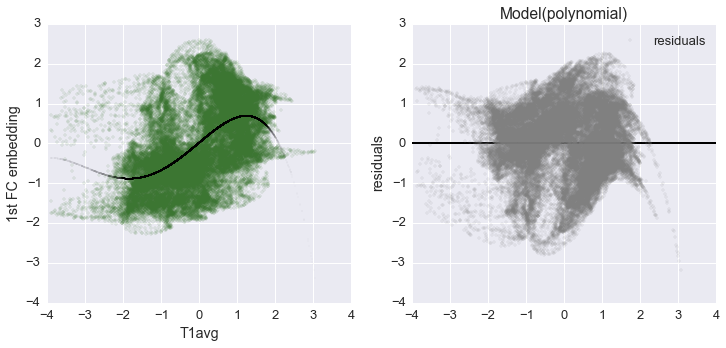

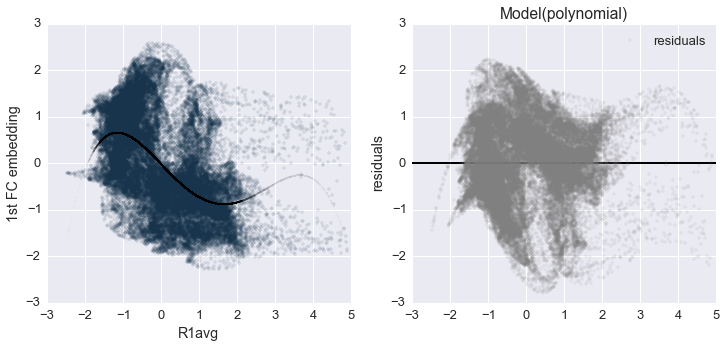

In [20]:
poly4_mod = lmfit.models.PolynomialModel(degree=4)

poly4_t1 = fit_simple(poly4_mod, 
                        x=t1_norm, y=embed1_t1_norm,
                        t1type='T1avg',
                        xlabel='T1avg',
                        ylabel='1st FC embedding', 
                        color=colors[3])


poly4_r1 = fit_simple(poly4_mod, 
                        x=r1_norm, y=embed1_r1_norm, 
                        t1type='R1avg',
                        xlabel='R1avg',
                        ylabel='1st FC embedding', 
                        color=colors[1])

### Polynomial fit degree=5

##### T1avg #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 9
    # data points      = 58921
    # variables        = 6
    chi-square         = 39995.900
    reduced chi-square = 0.679
[[Variables]]
    c0:   0.03443626 +/- 0.005528 (16.05%) (init= 0.03443626)
    c1:   0.84836681 +/- 0.007415 (0.87%) (init= 0.8483668)
    c2:  -0.06220113 +/- 0.007276 (11.70%) (init=-0.06220114)
    c3:  -0.17843508 +/- 0.004498 (2.52%) (init=-0.1784351)
    c4:  -0.00495964 +/- 0.001760 (35.49%) (init=-0.004959641)
    c5:   0.00735151 +/- 0.000594 (8.08%) (init= 0.007351514)
[[Correlations]] (unreported correlations are <  0.100)
    C(c2, c4)                    = -0.868 
    C(c1, c3)                    = -0.850 
    C(c4, c5)                    =  0.806 
    C(c3, c5)                    = -0.791 
    C(c0, c2)                    = -0.734 
    C(c2, c5)                    = -0.676 
    C(c1, c5)                    =  0.538 
    C(c0, c4)                    =  0.50

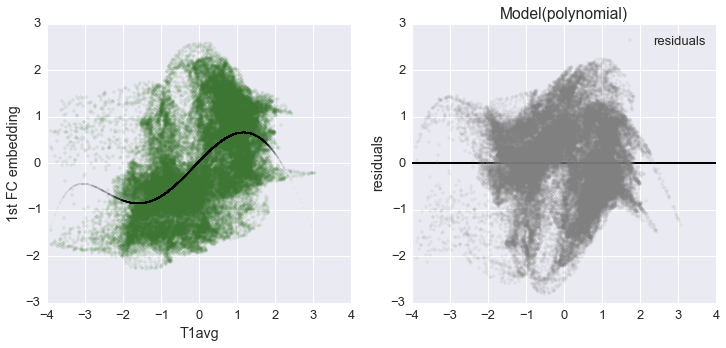

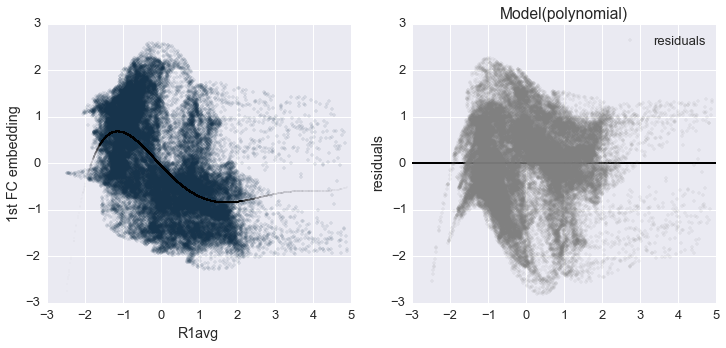

In [21]:
poly5_mod = lmfit.models.PolynomialModel(degree=5)

poly5_t1 = fit_simple(poly5_mod, 
                        x=t1_norm, y=embed1_t1_norm,
                        t1type='T1avg',
                        xlabel='T1avg',
                        ylabel='1st FC embedding', 
                        color=colors[3])


poly5_r1 = fit_simple(poly5_mod, 
                        x=r1_norm, y=embed1_r1_norm, 
                        t1type='R1avg',
                        xlabel='R1avg',
                        ylabel='1st FC embedding', 
                        color=colors[1])

### Polynomial fit degree=6

##### T1avg #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 10
    # data points      = 58921
    # variables        = 7
    chi-square         = 39680.569
    reduced chi-square = 0.674
[[Variables]]
    c0:  -0.00743342 +/- 0.005836 (78.52%) (init=-0.007433429)
    c1:   0.95030228 +/- 0.008760 (0.92%) (init= 0.9503023)
    c2:   0.05967470 +/- 0.009179 (15.38%) (init= 0.05967471)
    c3:  -0.28347158 +/- 0.006606 (2.33%) (init=-0.2834716)
    c4:  -0.06606009 +/- 0.003323 (5.03%) (init=-0.0660601)
    c5:   0.02471156 +/- 0.000997 (4.03%) (init= 0.02471156)
    c6:   0.00693990 +/- 0.000321 (4.62%) (init= 0.006939901)
[[Correlations]] (unreported correlations are <  0.100)
    C(c3, c5)                    = -0.910 
    C(c2, c4)                    = -0.883 
    C(c1, c3)                    = -0.881 
    C(c4, c6)                    = -0.850 
    C(c5, c6)                    =  0.805 
    C(c0, c2)                    = -0.750 
    C(c3, c6)          

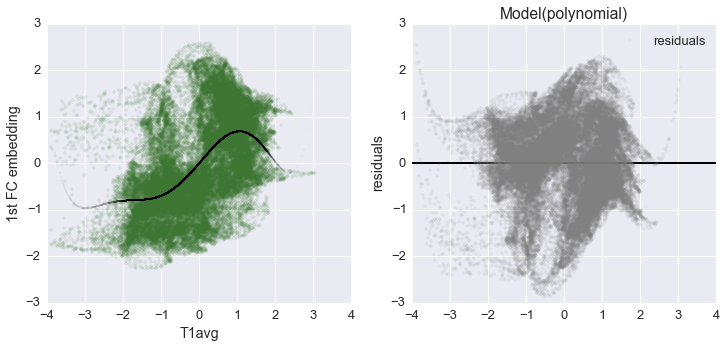

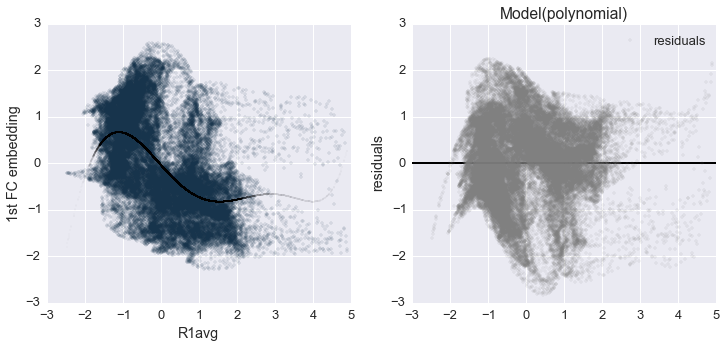

In [22]:
poly6_mod = lmfit.models.PolynomialModel(degree=6)

poly6_t1 = fit_simple(poly6_mod, 
                        x=t1_norm, y=embed1_t1_norm,
                        t1type='T1avg',
                        xlabel='T1avg',
                        ylabel='1st FC embedding', 
                        color=colors[3])


poly6_r1 = fit_simple(poly6_mod, 
                        x=r1_norm, y=embed1_r1_norm, 
                        t1type='R1avg',
                        xlabel='R1avg',
                        ylabel='1st FC embedding', 
                        color=colors[1])

### Polynomial fit degree=7

##### T1avg #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 11
    # data points      = 58921
    # variables        = 8
    chi-square         = 39668.987
    reduced chi-square = 0.673
[[Variables]]
    c0:  -0.01727372 +/- 0.006299 (36.47%) (init=-0.01727372)
    c1:   0.93347452 +/- 0.009653 (1.03%) (init= 0.9334745)
    c2:   0.09705743 +/- 0.012864 (13.25%) (init= 0.09705743)
    c3:  -0.26005741 +/- 0.008689 (3.34%) (init=-0.2600574)
    c4:  -0.08612653 +/- 0.005869 (6.82%) (init=-0.08612654)
    c5:   0.01643284 +/- 0.002231 (13.58%) (init= 0.01643285)
    c6:   0.00911437 +/- 0.000615 (6.74%) (init= 0.009114377)
    c7:   0.00074307 +/- 0.000179 (24.11%) (init= 0.0007430727)
[[Correlations]] (unreported correlations are <  0.100)
    C(c4, c6)                    = -0.954 
    C(c2, c4)                    = -0.934 
    C(c5, c7)                    = -0.895 
    C(c3, c5)                    = -0.890 
    C(c1, c3)                    = -0.881 
 

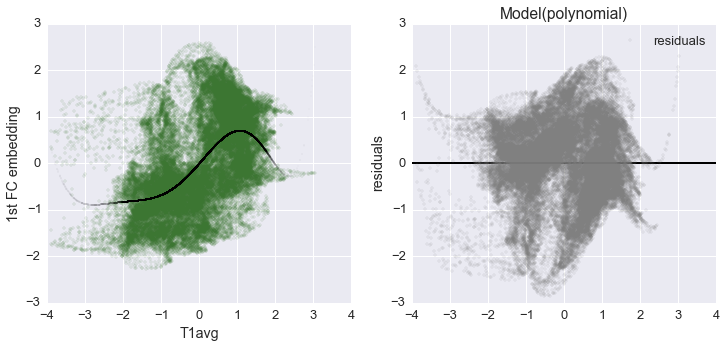

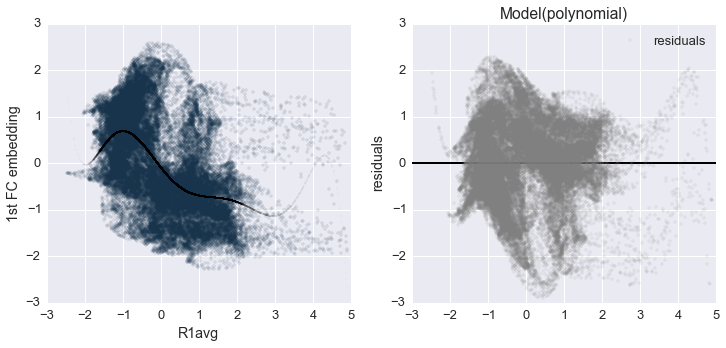

In [23]:
poly7_mod = lmfit.models.PolynomialModel(degree=7)

poly7_t1 = fit_simple(poly7_mod, 
                        x=t1_norm, y=embed1_t1_norm,
                        t1type='T1avg',
                        xlabel='T1avg',
                        ylabel='1st FC embedding', 
                        color=colors[3])


poly7_r1 = fit_simple(poly7_mod, 
                        x=r1_norm, y=embed1_r1_norm, 
                        t1type='R1avg',
                        xlabel='R1avg',
                        ylabel='1st FC embedding',  
                        color=colors[1])

### Linear step function with constant

##### T1avg #####
[[Model]]
    (Model(step, form='linear') + Model(linear, prefix='const_'))
[[Fit Statistics]]
    # function evals   = 51
    # data points      = 58921
    # variables        = 4
    chi-square         = 39078.060
    reduced chi-square = 0.663
[[Variables]]
    const_slope:       0 (fixed)
    const_intercept:  -0.64234333 +/- 0.005439 (0.85%) (init=-2.265477)
    amplitude:         1.26572726 +/- 0.007657 (0.60%) (init= 4.859743)
    sigma:             0.84261492 +/- 0.017308 (2.05%) (init= 0.9932274)
    center:           -0.33826552 +/- 0.010383 (3.07%) (init=-0.4166186)
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma, center)             = -0.861 
    C(const_intercept, amplitude)  = -0.710 
    C(const_intercept, center)   =  0.349 
    C(amplitude, sigma)          =  0.294 
    C(amplitude, center)         = -0.248 
    C(const_intercept, sigma)    = -0.209 

BIC -24147.1701487
AIC -24183.1059601

##### R1avg #####
[[Model]]
    (Model(ste

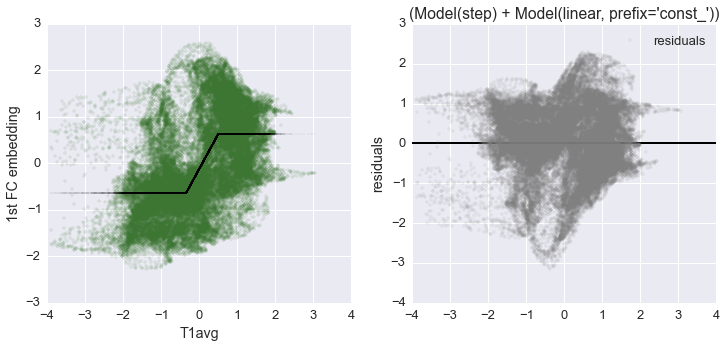

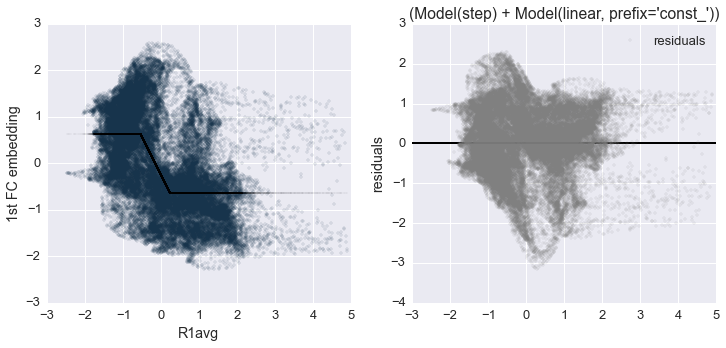

In [24]:
step_lin_mod = lmfit.models.StepModel(form='linear')

step_lin_const_t1 = fit_composite_const(step_lin_mod,
                                        x=t1_norm, y=embed1_t1_norm,
                                        t1type='T1avg',
                                        xlabel='T1avg',
                                        ylabel='1st FC embedding', 
                                        color=colors[3])

step_lin_const_r1 = fit_composite_const(step_lin_mod, 
                                        x=r1_norm, y=embed1_r1_norm, 
                                        t1type='R1avg',
                                        xlabel='R1avg',
                                        ylabel='1st FC embedding', 
                                        color=colors[1])

### Arctan function + constant

##### T1avg #####
[[Model]]
    (Model(step, form='atan') + Model(linear, prefix='const_'))
[[Fit Statistics]]
    # function evals   = 48
    # data points      = 58921
    # variables        = 4
    chi-square         = 39228.086
    reduced chi-square = 0.666
[[Variables]]
    const_slope:       0 (fixed)
    const_intercept:  -0.72109780 +/- 0.007857 (1.09%) (init=-2.265477)
    amplitude:         1.44165885 +/- 0.014350 (1.00%) (init= 4.859743)
    sigma:             0.18514443 +/- 0.008587 (4.64%) (init= 0.9932274)
    center:            0.08996574 +/- 0.005527 (6.14%) (init=-0.4166186)
[[Correlations]] (unreported correlations are <  0.100)
    C(const_intercept, amplitude)  = -0.860 
    C(amplitude, sigma)          =  0.811 
    C(const_intercept, sigma)    = -0.682 
    C(const_intercept, center)   =  0.238 

BIC -23921.3975227
AIC -23957.333334

##### R1avg #####
[[Model]]
    (Model(step, form='atan') + Model(linear, prefix='const_'))
[[Fit Statistics]]
    # function evals

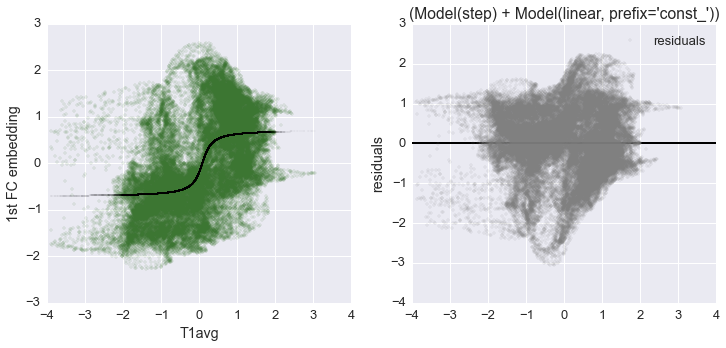

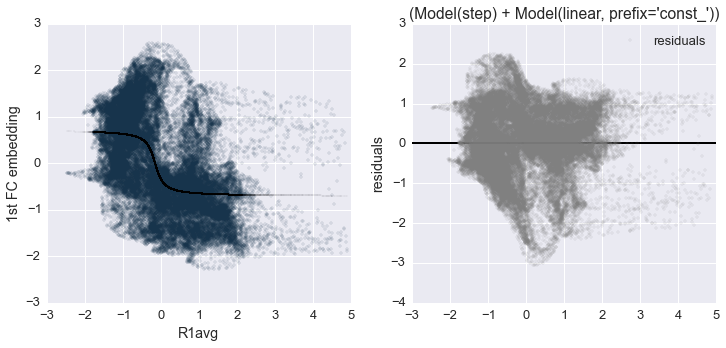

In [25]:
step_atan_mod = lmfit.models.StepModel(form='atan')

step_atan_const_t1 = fit_composite_const(step_atan_mod,
                                        x=t1_norm, y=embed1_t1_norm,
                                        t1type='T1avg',
                                        xlabel='T1avg',
                                        ylabel='1st FC embedding', 
                                        color=colors[3])

step_atan_const_r1 = fit_composite_const(step_atan_mod, 
                                        x=r1_norm, y=embed1_r1_norm, 
                                        t1type='R1avg',
                                        xlabel='R1avg',
                                        ylabel='1st FC embedding', 
                                        color=colors[1])

### Logistic function + constant

##### T1avg #####
[[Model]]
    (Model(step, form='logistic') + Model(linear, prefix='const_'))
[[Fit Statistics]]
    # function evals   = 65
    # data points      = 58921
    # variables        = 4
    chi-square         = 39166.437
    reduced chi-square = 0.665
[[Variables]]
    const_slope:       0 (fixed)
    const_intercept:  -0.64269189 +/- 0.005694 (0.89%) (init=-2.265477)
    amplitude:         1.27309627 +/- 0.008607 (0.68%) (init= 4.859743)
    sigma:             0.14933012 +/- 0.004881 (3.27%) (init= 0.9932274)
    center:            0.08777936 +/- 0.005387 (6.14%) (init=-0.4166186)
[[Correlations]] (unreported correlations are <  0.100)
    C(const_intercept, amplitude)  = -0.728 
    C(amplitude, sigma)          =  0.513 
    C(const_intercept, sigma)    = -0.337 
    C(const_intercept, center)   =  0.329 

BIC -24014.0682871
AIC -24050.0040984

##### R1avg #####
[[Model]]
    (Model(step, form='logistic') + Model(linear, prefix='const_'))
[[Fit Statistics]]
    # funct

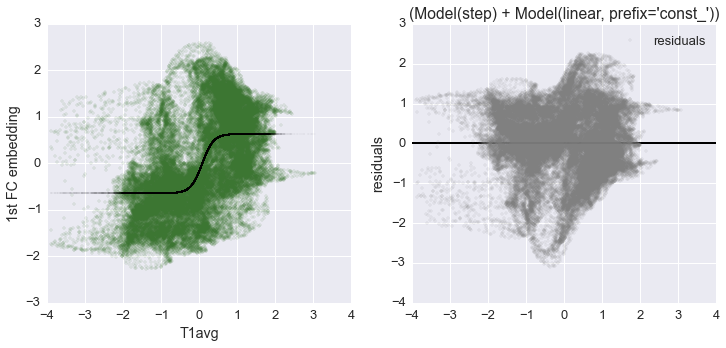

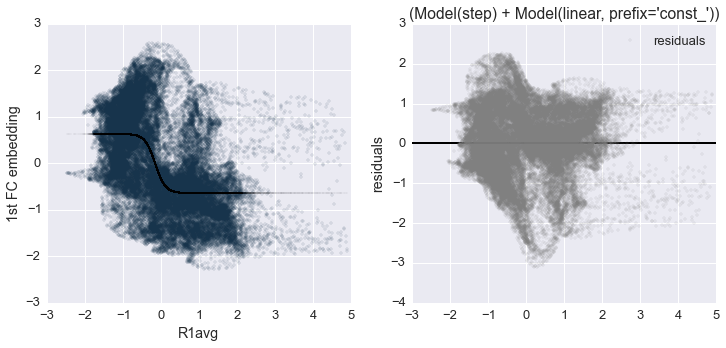

In [26]:
step_log_mod = lmfit.models.StepModel(form='logistic')

step_log_const_t1 = fit_composite_const(step_log_mod,
                                        x=t1_norm, y=embed1_t1_norm,
                                        t1type='T1avg',
                                        xlabel='T1avg',
                                        ylabel='1st FC embedding',  
                                        color=colors[3])

step_log_const_r1 = fit_composite_const(step_log_mod, 
                                        x=r1_norm, y=embed1_r1_norm, 
                                        t1type='R1avg',
                                        xlabel='R1avg',
                                        ylabel='1st FC embedding', 
                                        color=colors[1])

### Error function + constant

##### T1avg #####
[[Model]]
    (Model(step, form='erf') + Model(linear, prefix='const_'))
[[Fit Statistics]]
    # function evals   = 88
    # data points      = 58921
    # variables        = 4
    chi-square         = 39138.235
    reduced chi-square = 0.664
[[Variables]]
    const_slope:       0 (fixed)
    const_intercept:  -0.63986724 +/- 0.005585 (0.87%) (init=-2.265477)
    amplitude:         1.26624916 +/- 0.008221 (0.65%) (init= 4.859743)
    sigma:             0.35529618 +/- 0.010755 (3.03%) (init= 0.9932274)
    center:            0.08819186 +/- 0.005402 (6.13%) (init=-0.4166186)
[[Correlations]] (unreported correlations are <  0.100)
    C(const_intercept, amplitude)  = -0.717 
    C(amplitude, sigma)          =  0.450 
    C(const_intercept, center)   =  0.337 
    C(const_intercept, sigma)    = -0.292 

BIC -24056.5097838
AIC -24092.4455952

##### R1avg #####
[[Model]]
    (Model(step, form='erf') + Model(linear, prefix='const_'))
[[Fit Statistics]]
    # function evals 

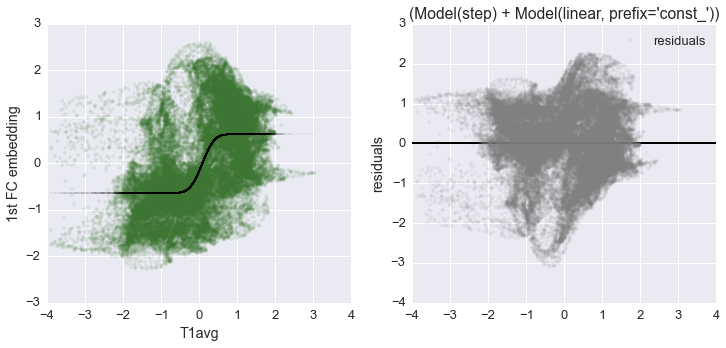

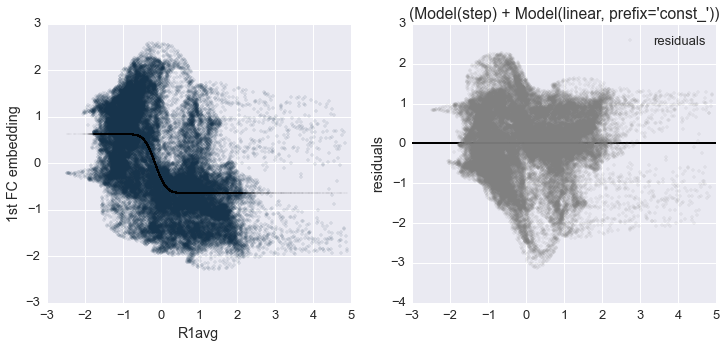

In [27]:
step_erf_mod = lmfit.models.StepModel(form='erf')

step_erf_const_t1 = fit_composite_const(step_erf_mod,
                                        x=t1_norm, y=embed1_t1_norm,
                                        t1type='T1avg',
                                        xlabel='T1avg',
                                        ylabel='1st FC embedding', 
                                        color=colors[3])

step_erf_const_r1 = fit_composite_const(step_erf_mod, 
                                        x=r1_norm, y=embed1_r1_norm, 
                                        t1type='R1avg',
                                        xlabel='R1avg',
                                        ylabel='1st FC embedding', 
                                        color=colors[1])

### Compare different models

In [28]:
names = ['linear', 'quadratic', 'poly3', 'poly4', 'poly5', 'poly6', 'poly7', 
         'step lin', 'step atan', 'step log', 'step erf']

t1_results = [lin_t1, quad_t1, poly3_t1, poly4_t1, poly5_t1, poly6_t1, poly7_t1, 
                     step_lin_const_t1, step_atan_const_t1, step_log_const_t1, step_erf_const_t1]

r1_results = [lin_r1, quad_r1, poly3_r1, poly4_r1, poly5_r1, poly6_r1, poly7_r1, 
                     step_lin_const_r1, step_atan_const_r1, step_log_const_r1, step_erf_const_r1]

df = pd.DataFrame()

df['Value']=[m.bic for m in t1_results]+[m.aic for m in t1_results]+[m.bic for m in r1_results]+[m.aic for m in r1_results]
df['Model']=4*names
df['Criterion']=len(t1_results)*['BIC T1']+len(t1_results)*['AIC T1']+len(r1_results)*['BIC R1']+len(r1_results)*['AIC R1']


df2 = pd.DataFrame()

df2['Model'] = 2*names
df2['Datatype'] = len(names)*['T1']+len(names)*['R1']
df2['Chisqr'] = [m.chisqr for m in t1_results] + [m.chisqr for m in r1_results]
df2['Reduced Chi'] = [m.redchi for m in t1_results] + [m.redchi for m in r1_results]

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


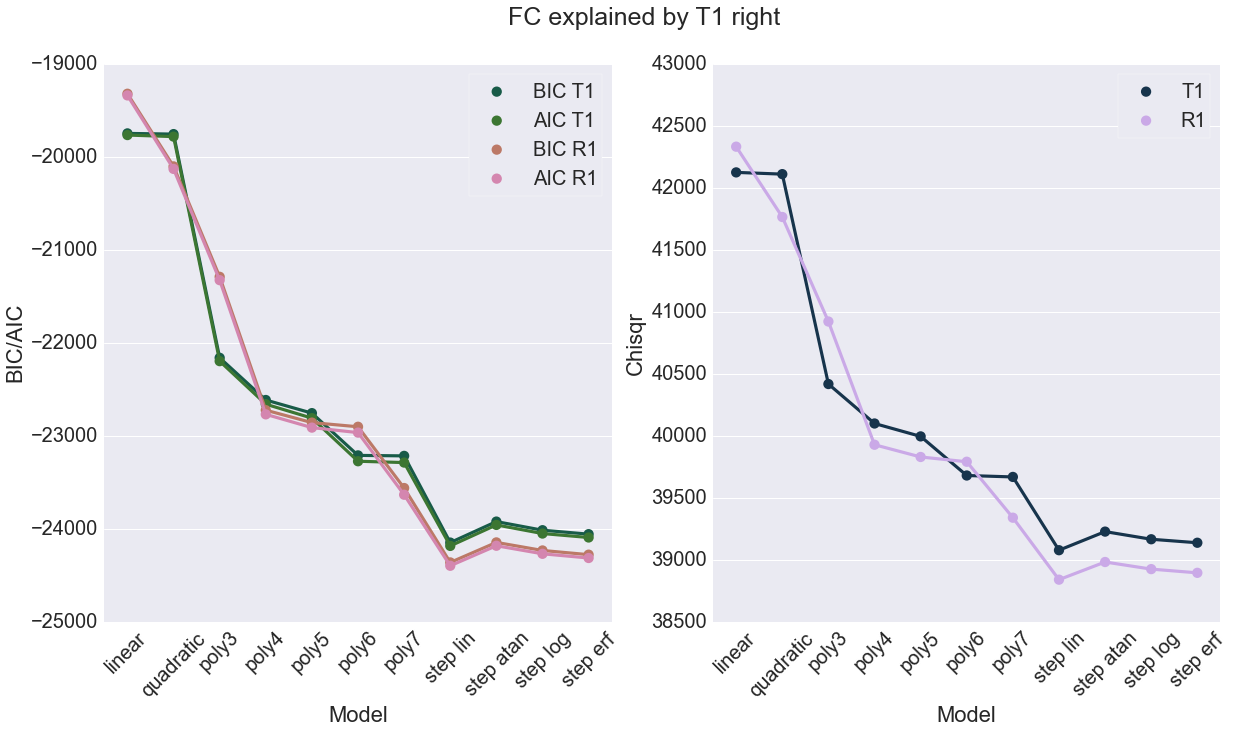

In [29]:
sns.set_context('notebook', font_scale=2)

fig=plt.figure(figsize=(20,10))
fig.add_subplot(121)
#sns.barplot(data=df, y='Model', x='Value', hue='Criterion', 
#            palette=[colors[2], colors[3], colors[5], colors[6]])
sns.pointplot(data=df, x='Model', y='Value', hue='Criterion', linewidth=0,
             palette=[colors[2], colors[3], colors[5], colors[6]])
plt.legend(loc=1, frameon=True)
plt.ylabel('BIC/AIC')
plt.xticks(rotation=45)

fig.add_subplot(122)
#sns.barplot(data=df2, y='Model', x='Reduced Chi', hue='Datatype', 
#            palette=[colors[3], colors[5]])
sns.pointplot(data=df2, x='Model', y='Chisqr', hue='Datatype', 
           palette=[colors[1], colors[7]])
plt.legend(loc=1, frameon=True)
plt.ylabel('Chisqr')
plt.xticks(rotation=45);

if hemi=='lh':
    hemistring='left'
elif hemi=='rh':
    hemistring='right'
else:
    hemistring='both'
plt.suptitle('FC explained by T1 %s'%hemistring, fontsize=25)

In [30]:
t1_df = pd.DataFrame()
t1_df['Model']=names
t1_df['T1 BIC']=[m.bic for m in t1_results]
t1_df['T1 AIC']=[m.bic for m in t1_results]
t1_df['T1 Chisqr']=[m.chisqr for m in t1_results]
t1_df

Model        T1 BIC        T1 AIC     T1 Chisqr
0      linear -19747.334311 -19747.334311  42125.002240
1   quadratic -19754.938441 -19754.938441  42111.000226
2       poly3 -22160.394039 -22160.394039  40418.213210
3       poly4 -22614.159342 -22614.159342  40099.981171
4       poly5 -22755.306053 -22755.306053  39995.899977
5       poly6 -23209.701526 -23209.701526  39680.568598
6       poly7 -23214.917575 -23214.917575  39668.986797
7    step lin -24147.170149 -24147.170149  39078.060011
8   step atan -23921.397523 -23921.397523  39228.086000
9    step log -24014.068287 -24014.068287  39166.436683
10   step erf -24056.509784 -24056.509784  39138.234791

In [31]:
r1_df = pd.DataFrame()
r1_df['Model']=names
r1_df['R1 BIC']=[m.bic for m in r1_results]
r1_df['R1 AIC']=[m.bic for m in r1_results]
r1_df['R1 Chisqr']=[m.chisqr for m in r1_results]
r1_df

Model        R1 BIC        R1 AIC     R1 Chisqr
0      linear -19321.001115 -19321.001115  42332.393633
1   quadratic -20102.301433 -20102.301433  41765.286523
2       poly3 -21289.478349 -21289.478349  40922.412918
3       poly4 -22723.472328 -22723.472328  39928.645506
4       poly5 -22857.085089 -22857.085089  39829.930414
5       poly6 -22901.859893 -22901.859893  39791.514594
6       poly7 -23560.713924 -23560.713924  39340.259062
7    step lin -24360.569382 -24360.569382  38840.536268
8   step atan -24145.313108 -24145.313108  38982.941426
9    step log -24231.873319 -24231.873319  38925.613909
10   step erf -24277.108861 -24277.108861  38895.688643